In [150]:
import pandas as pd

## Reading Data

In [42]:
pd1 = pd.read_csv("train_1000/train_1000_features.csv")
pd2 = pd.read_csv("train_1000/train_1000_features2.csv") 
pd3 = pd.read_csv("train_1000/train_1000_features3.csv")
pd4 = pd.read_csv("train_1000/train_1000_features4.csv")
pd5 = pd.read_csv("train_1000/train_1000_features5.csv")
pd_all = pd.concat([pd1, pd2, pd3, pd4, pd5]) \
        .reset_index() \
        .drop(columns=['Unnamed: 0', 'index']) \
        .dropna()
pd_all.head()

,mean_pitch,mean_intensity,sd_pitch,sd_intensity,duration,speaking_rate,jitter,shimmer,tag
0,0.439332,-0.233840,23.434147,12.741367,3.92,2.806122,0.016667,0.073849,qy
1,-0.333770,-0.065550,15.809203,13.735634,9.64,3.215768,0.017093,0.081315,sd
2,-0.195737,0.023572,3.449232,11.928231,2.20,0.454545,0.009435,0.081687,%
3,-0.238647,-0.056787,18.148676,12.747733,5.92,3.378378,0.007669,0.071836,sd
4,0.093581,0.431376,5.741084,4.398988,0.12,8.333333,0.008277,0.097482,b


## PCA

In [177]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA.fit_transform
# https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn
# https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from itertools import combinations 

In [123]:
features = ['mean_pitch', 'mean_intensity', 'sd_pitch', 'sd_intensity', 
            'duration', 'speaking_rate', 'jitter', 'shimmer']
x = pd_all.loc[:, features].values
y = pd_all.loc[:,['tag']].values
x = StandardScaler().fit_transform(x)

In [187]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2'])
finalDf = pd.concat([principalDf, pd_all[['tag']]], axis = 1)
finalDf.head()

,pc1,pc2,tag
0,0.211246,-1.452196,qy
1,1.558248,-1.359709,sd
2,-0.239579,-1.375216,%
3,0.274774,-1.591206,sd
4,-3.125002,1.776289,b


In [138]:
pd.DataFrame(pca.components_, columns=features,index = ['pc1','pc2'])

,mean_pitch,mean_intensity,sd_pitch,sd_intensity,duration,speaking_rate,jitter,shimmer
pc1,-0.344425,-0.336857,0.441407,0.411283,0.380497,-0.231649,0.356381,0.280104
pc2,-0.147081,0.373304,0.262344,-0.322740,-0.275673,0.408124,0.443718,0.476004


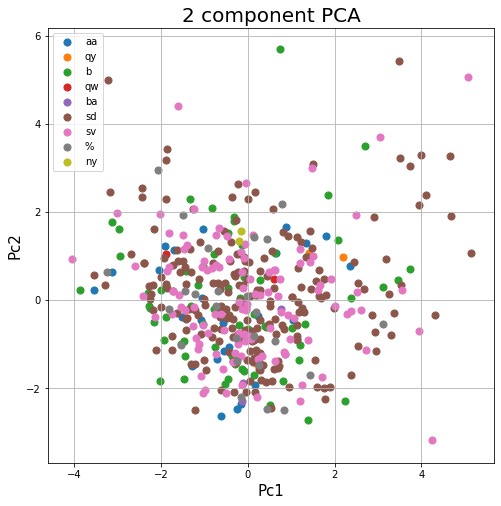

In [134]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Pc1', fontsize = 15)
ax.set_ylabel('Pc2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = list(set(pd_all['tag']))
for target in targets:
    indicesToKeep = finalDf['tag'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'pc1']
               , finalDf.loc[indicesToKeep, 'pc2']
               , s = 50)
    ax.legend(targets)
    ax.grid()

In [65]:
pca.explained_variance_ratio_

array([0.30168388, 0.23408089])

In [188]:
components, features_list = [], []
for new_features in list(combinations(features, 6)):
    drop_features = [f for f in features if f not in new_features]
    pd2 = pd_all.drop(columns=drop_features)
    x = pd2.loc[:, new_features].values
    y = pd2.loc[:,['tag']].values
    x = StandardScaler().fit_transform(x)
    pca = PCA(n_components=1)
    principalComponents = pca.fit_transform(x)
    features_list.append((pca.explained_variance_ratio_[0], new_features, pca.components_))
#     if len(pca.explained_variance_ratio_)==4:
#         print(new_features, sum(pca.explained_variance_ratio_), len(pca.explained_variance_ratio_))
# pd.DataFrame(pca.components_, columns=features)
features_list.sort(reverse=True)
features_list[0]

(0.3763634982992282,
 ('mean_pitch', 'sd_pitch', 'sd_intensity', 'duration', 'jitter', 'shimmer'),
 array([[-0.40461866,  0.51931039,  0.2785039 ,  0.27845798,  0.48732814,
          0.41714321]]))

## Best feature selection

### K-Best

In [176]:
# https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
# https://stackoverflow.com/questions/25792012/feature-selection-using-scikit-learn
# https://machinelearningmastery.com/feature-selection-machine-learning-python/
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [155]:
features = ['mean_pitch', 'mean_intensity', 'sd_pitch', 'sd_intensity', 
            'duration', 'speaking_rate', 'jitter', 'shimmer']
xDF = pd_all.loc[:, features]
y = pd_all.loc[:,['tag']]
xSC = StandardScaler().fit_transform(xDF)
x = pd.DataFrame(xSC, index=xDF.index, columns=xDF.columns)

In [175]:
bestfeatures = SelectKBest(score_func=f_classif, k=6)
fit = bestfeatures.fit(x,y.to_numpy().T[0])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
featureScores.nlargest(6,'Score')

,Specs,Score
4,duration,13.303480
3,sd_intensity,8.630644
2,sd_pitch,3.427214
7,shimmer,2.992644
5,speaking_rate,2.750573
0,mean_pitch,2.195402


### Feature Importance

[0.1056754  0.11342163 0.12190691 0.12440309 0.16031873 0.15473193
 0.11273764 0.10680468]


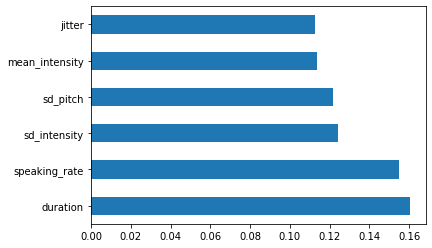

In [174]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(x,y.to_numpy().T[0])
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(6).plot(kind='barh')
plt.show()

### Recursive Feature Elimination

In [158]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [173]:
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 6)
fit = rfe.fit(x, y.to_numpy().T[0])
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)
[f for i,f in enumerate(features) if fit.support_[i]]

Num Features: 6
Selected Features: [False  True  True  True  True  True False  True]
Feature Ranking: [3 1 1 1 1 1 2 1]


['mean_intensity',
 'sd_pitch',
 'sd_intensity',
 'duration',
 'speaking_rate',
 'shimmer']